# Eye Track, Initial Exploration

In [84]:
import json
import re
import ast
import pandas as pd
import seaborn as sns
from datetime import datetime
import time
import hypertools as hyp
import numpy as np
from matplotlib import pyplot as plt
import os

# Parse json file 

In [85]:
class parseFile():
    def __init__(self, file):
        self.file = file
    def parse(self):
        json_data = open(self.file).read()
        return(json_data)

In [166]:
def load(path):
    
    data = []
    files = [f for f in os.listdir(path)]
    
    for x in files:
        #if os.path.isfile(path+x):
        newFile = parseFile(path+x)
        data1 = newFile.parse()

        for a,b in zip(['true','false'], ['True', 'False']):
            data1 = data1.replace(a, b)

        data1 = data1.split('\n')
        data1 = [x for x in data1 if "tracker" in x]
        data.extend(data1)
        
    return(data)


def df_create(data):
    
    dict_list = [ast.literal_eval(x) for x in data]
    dict_list = [x['values']['frame'] for x in dict_list if 'values' in x]

    df = pd.DataFrame(dict_list)
    
    # RIGHT and LEFT EYE
    for eye in ['righteye','lefteye']:
        for coord in ['x','y']:
            df[coord+'Raw_'+eye] = [df[eye][row]['raw'][coord] for row in df.index.values]
        
    df['av_x_coord'] = df[['xRaw_righteye', 'xRaw_lefteye']].mean(axis=1)
    df['av_y_coord'] = df[['yRaw_righteye', 'yRaw_lefteye']].mean(axis=1) 
    
    # FIIX TIMESTAMP
    df['timestamp']=[time.mktime(time.strptime(x[:], "%Y-%m-%d %H:%M:%S.%f")) for x in df['timestamp']]
    
    return(df)
    

# Plot Eye Track Data from Presentation Runs only

In [217]:
def pres_gaze(subdir, eye_df, interval='images'):
    '''
    input: subject's experiment df and eye track df
    output: list of eye tracking df's, one for each presentation trial 
    '''
    
    pres_gaze = []
    
    #files = [f for f in os.listdir(subdir) if os.path.isfile(f)]
    for f in os.listdir(subdir):
        
        if 'pres' in f:
            
            pres_df = pd.read_csv(subdir+'/'+f)

            if interval == 'images':
                start = pres_df['Stimulus Onset']
                end = pres_df['Stimulus End'] #+pres_df['Attention Reaction Time (s)'][9]
                
            else:
                start = pres_df['Stimulus Onset'][0]
                end = pres_df['Stimulus End'][9]
            
            for x,y in zip(start,end):
                pres_gaze.append(eye_df.loc[(eye_df['timestamp']>x) & 
                                            (eye_df['timestamp']<y) & 
                                            (eye_df['xRaw_righteye']>0.0) & 
                                            (eye_df['xRaw_lefteye']>0.0)])      
                
    return(pres_gaze)


def gaze_plot(df_list, plot=True, run=None):

    props = []
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    # for each possible number rating
    if type(run) is int:
        ax1.plot(df_list[run]['av_x_coord'], df_list[run]['av_y_coord'], '.')
        
    else:
        for x in df_list:
            ax1.plot(x['av_x_coord'], x['av_y_coord'], '.')
            props.append(x.loc[(x['av_x_coord']>744) & 
                                    (x['av_x_coord']<1304)])

    ax1.plot(1304,1152/2.0,'*',markersize=20, color='black')
    ax1.plot(744,1152/2.0,'*',markersize=20, color='black')
    
    middle = 2048/2.0
    quarter = (1304-744)/4.0
    ax1.axvline(x=middle+quarter, ymin=0, ymax=2000) #, **kwargs)
    ax1.axvline(x=middle-quarter, ymin=0, ymax=2000) #, **kwargs)
    
    if plot:
        # plt.legend(loc='upper left');
        plt.ylim(0, 1152)
        plt.xlim(0, 2048)
        plt.show()
    
    return(props)
        

# Average gaze points (pres runs)

the blob where the vast majority of gazepoints lie (approx x=1,000) shows the shape I would expect-- roughly most gaze points at center, with the occasional right/left deviation (I was pretty tired when I ran myself here, so there may be more eye movement than usual). It doesn't seem crazy that I might have occasionally glanced to the left of the screen, but the line at x=500 seems really strange.

In [218]:
y1 = np.linspace(0, .1, 1000)


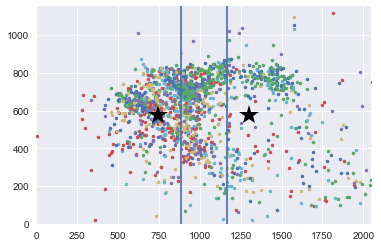

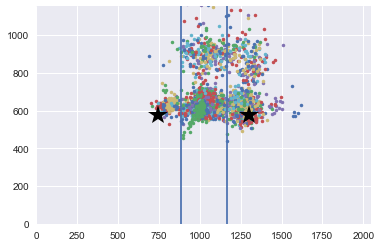

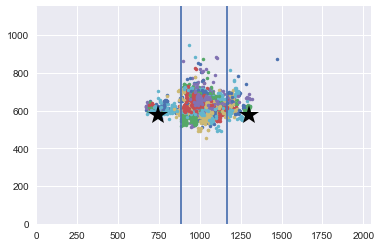

KeyError: 'frame'

In [219]:
data_dir = '/Users/Student/Desktop/attention-memory-task/data/'

for sub in os.listdir(data_dir):
    loaded = load(data_dir+sub+'/'+'eye_data/')
    df = df_create(loaded)
    df_list = pres_gaze(data_dir+sub, df, interval='images')
    gaze_plot(df_list)
    
    #prop = prop_cent()
    
#     sns.jointplot("av_x_coord", "av_y_coord", data=pd.concat(df_list), color="k", xlim=(0,2048), ylim=(0,1152)).plot_joint(sns.kdeplot, zorder=0, n_levels=6)
#     plt.plot(1304, 1152/2.0, '*',markersize=20, color='aqua')
#     plt.plot(744, 1152/2.0, '*',markersize=20, color='aqua')

#     ax1.plot(1304,1152/2.0,'*',markersize=20, color='black')
#     ax1.plot(744,1152/2.0,'*',markersize=20, color='black')    